<a href="https://colab.research.google.com/github/kkingo/AndroidApp/blob/master/Gaussian_Belief_Propagation_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Belief Propagation Library

Author: [Joseph Ortiz](https://joeaortiz.github.io/)

License: [Creative Commons Attribution 4.0 International
](https://github.com/gaussianBP/gaussianBP.github.io/blob/master/LICENSE)

This library is provided as accompanying code to our article [A visual introduction to Gaussian Belief Propagation
](https://gaussianbp.github.io/).

In [ ]:
#@title Imports
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#@title Utility Functions

from typing import List, Callable, Optional, Union

class Gaussian:
    def __init__(self, dim: int, eta: Optional[torch.Tensor]=None, lam: Optional[torch.Tensor]=None, type: torch.dtype = torch.float):
        self.dim = dim

        if eta is not None and eta.shape == torch.Size([dim]):
            self.eta = eta.type(type)
        else:
            self.eta = torch.zeros(dim, dtype=type)

        if lam is not None and lam.shape == torch.Size([dim, dim]):
            self.lam = lam.type(type)
        else:
            self.lam = torch.zeros([dim, dim], dtype=type)

    def mean(self) -> torch.Tensor:
        return torch.matmul(torch.inverse(self.lam), self.eta)

    def cov(self) -> torch.Tensor:
        return torch.inverse(self.lam)

    def mean_and_cov(self) -> List[torch.Tensor]:
        cov = self.cov()
        mean = torch.matmul(cov, self.eta)
        return [mean, cov]

    def set_with_cov_form(self, mean: torch.Tensor, cov: torch.Tensor) -> None:
        self.lam = torch.inverse(cov)
        self.eta = self.lam @ mean

"""
    Defines squared loss functions that correspond to Gaussians. 
    Robust losses are implemented by scaling the Gaussian covariance.
"""

class SquaredLoss(): 
    def __init__(self, dofs: int, diag_cov: Union[float, torch.Tensor]) -> None:
        """
            dofs: dofs of the measurement
            cov: diagonal elements of covariance matrix
        """
        assert diag_cov.shape == torch.Size([dofs])
        mat = torch.zeros(dofs, dofs, dtype=diag_cov.dtype)
        mat[range(dofs), range(dofs)] = diag_cov
        self.cov = mat
        self.effective_cov = mat.clone()

    def get_effective_cov(self, residual: torch.Tensor) -> None:
        """ Returns the covariance of the Gaussian (squared loss) that matches the loss at the error value. """
        self.effective_cov = self.cov.clone()

    def robust(self) -> bool:
        return not torch.equal(self.cov, self.effective_cov)


class HuberLoss(SquaredLoss):
    def __init__(self, dofs: int, diag_cov: Union[float, torch.Tensor], stds_transition: float) -> None:
        """ 
            stds_transition: num standard deviations from minimum at which quadratic loss transitions to linear 
        """
        SquaredLoss.__init__(self, dofs, diag_cov)
        self.stds_transition = stds_transition

    def get_effective_cov(self, residual: torch.Tensor) -> None:
        mahalanobis_dist = torch.sqrt(residual @ torch.inverse(self.cov) @ residual)
        if mahalanobis_dist > self.stds_transition:
            self.effective_cov = self.cov * mahalanobis_dist**2 / (2 * self.stds_transition * mahalanobis_dist - self.stds_transition**2)
        else:
            self.effective_cov = self.cov.clone()


class TukeyLoss(SquaredLoss):
    def __init__(self, dofs: int, diag_cov: Union[float, torch.Tensor], stds_transition: float) -> None:
        """ 
            stds_transition: num standard deviations from minimum at which quadratic loss transitions to constant 
        """
        SquaredLoss.__init__(self, dofs, diag_cov)
        self.stds_transition = stds_transition

    def get_effective_cov(self, residual: torch.Tensor) -> None:
        mahalanobis_dist = torch.sqrt(residual @ torch.inverse(self.cov) @ residual)
        if mahalanobis_dist > self.stds_transition:
            self.effective_cov = self.cov * mahalanobis_dist**2 / self.stds_transition**2
        else:
            self.effective_cov = self.cov.clone()

class MeasModel: 
    def __init__(self, meas_fn: Callable, jac_fn: Callable, loss: SquaredLoss, *args) -> None:
        self._meas_fn = meas_fn
        self._jac_fn = jac_fn
        self.loss = loss
        self.args = args
        self.linear = True

    def jac_fn(self, x: torch.Tensor) -> torch.Tensor:
        return self._jac_fn(x, *self.args)

    def meas_fn(self, x: torch.Tensor) -> torch.Tensor:
        return self._meas_fn(x, *self.args)


In [ ]:
#@title Main GBP Functions

"""
    Defines classes for variable nodes, factor nodes and edges and factor graph.
"""

class GBPSettings:
    def __init__(self, 
                 damping: float = 0.,
                 beta: float = 0.1,
                 num_undamped_iters: int = 5,
                 min_linear_iters: int = 10,
                 dropout: float = 0.,
                 reset_iters_since_relin: List[int] = [],
                 type: torch.dtype = torch.float) -> None:

        # Parameters for damping the eta component of the message
        self.damping = damping 
        self.num_undamped_iters = num_undamped_iters  # Number of undamped iterations after relinearisation before damping is set to damping

        self.dropout = dropout 

        # Parameters for just in time factor relinearisation
        self.beta = beta  # Threshold absolute distance between linpoint and adjacent belief means for relinearisation.
        self.min_linear_iters = min_linear_iters  # Minimum number of linear iterations before a factor is allowed to realinearise.
        self.reset_iters_since_relin = reset_iters_since_relin

    def get_damping(self, iters_since_relin: int) -> float:
        if iters_since_relin > self.num_undamped_iters:
            return self.damping
        else: 
            return 0.


class FactorGraph:
    def __init__(self, gbp_settings: GBPSettings = GBPSettings()) -> None:
        self.var_nodes = []
        self.factors = []
        self.gbp_settings = gbp_settings

    def add_var_node(self, 
                    dofs: int, 
                    prior_mean: Optional[torch.Tensor] = None, 
                    prior_diag_cov: Optional[Union[float, torch.Tensor]] = None,
                    properties: dict = {}) -> None:
        variableID = len(self.var_nodes)
        self.var_nodes.append(VariableNode(variableID, dofs, properties=properties))
        if prior_mean is not None and prior_diag_cov is not None:
            prior_cov = torch.zeros(dofs, dofs, dtype=prior_diag_cov.dtype)
            prior_cov[range(dofs), range(dofs)] = prior_diag_cov
            self.var_nodes[-1].prior.set_with_cov_form(prior_mean, prior_cov)
            self.var_nodes[-1].update_belief()
            
    def add_factor(self, adj_var_ids: List[int], 
                    measurement: torch.Tensor, 
                    meas_model: MeasModel,
                    properties: dict = {}) -> None:
        factorID = len(self.factors)
        adj_var_nodes = [self.var_nodes[i] for i in adj_var_ids]
        self.factors.append(Factor(factorID, adj_var_nodes, measurement, meas_model, properties=properties))
        for var in adj_var_nodes:
            var.adj_factors.append(self.factors[-1])

    def update_all_beliefs(self) -> None:
        for var_node in self.var_nodes:
            var_node.update_belief()

    def compute_all_messages(self, apply_dropout: bool = True) -> None:
        for factor in self.factors:
            if apply_dropout and random.random() > self.gbp_settings.dropout or not apply_dropout:
                damping = self.gbp_settings.get_damping(factor.iters_since_relin)
                factor.compute_messages(damping)

    def linearise_all_factors(self) -> None:
        for factor in self.factors:
            factor.compute_factor()

    def robustify_all_factors(self) -> None:
        for factor in self.factors:
            factor.robustify_loss()

    def jit_linearisation(self) -> None:
        """
            Check for all factors that the current estimate is close to the linearisation point. 
            If not, relinearise the factor distribution.
            Relinearisation is only allowed at a maximum frequency of once every min_linear_iters iterations.
        """
        for factor in self.factors:
            if not factor.meas_model.linear:
                adj_belief_means = factor.get_adj_means()
                factor.iters_since_relin += 1
                if torch.norm(factor.linpoint - adj_belief_means) > self.gbp_settings.beta and factor.iters_since_relin >= self.gbp_settings.min_linear_iters:
                    factor.compute_factor()

    def synchronous_iteration(self) -> None:
        self.robustify_all_factors()
        self.jit_linearisation()  # For linear factors, no compute is done
        self.compute_all_messages()
        self.update_all_beliefs()

    def gbp_solve(self, n_iters: Optional[int] = 20, converged_threshold: Optional[float] = 1e-6, include_priors: bool = True) -> None:
        energy_log = [self.energy()]
        print(f"\nInitial Energy {energy_log[0]:.5f}")
        i = 0
        count = 0
        not_converged = True
        while not_converged and i < n_iters: 
            self.synchronous_iteration()
            if i in self.gbp_settings.reset_iters_since_relin:
                for f in self.factors:
                    f.iters_since_relin = 1

            energy_log.append(self.energy(include_priors=include_priors))
            print(
                f"Iter {i+1}  --- "
                f"Energy {energy_log[-1]:.5f} --- "
                # f"Belief means: {self.belief_means().numpy()} --- "
                # f"Robust factors: {[factor.meas_model.loss.robust() for factor in self.factors]}"
                # f"Relins: {sum([(factor.iters_since_relin==0 and not factor.meas_model.linear) for factor in self.factors])}"
                  )
            i += 1
            if abs(energy_log[-2] - energy_log[-1]) < converged_threshold:
                count += 1
                if count == 3:
                    not_converged = False
            else:
                count = 0

    def energy(self, eval_point: torch.Tensor = None, include_priors: bool = True) -> float:
        """ Computes the sum of all of the squared errors in the graph using the appropriate local loss function. """
        if eval_point is None:
            energy = sum([factor.get_energy() for factor in self.factors])
        else:
            var_dofs = torch.tensor([v.dofs for v in self.var_nodes])
            var_ix = torch.cat([torch.tensor([0]), torch.cumsum(var_dofs, dim=0)[:-1]])
            energy = 0.
            for f in self.factors:
                local_eval_point = torch.cat([eval_point[var_ix[v.variableID]: var_ix[v.variableID] + v.dofs] for v in f.adj_var_nodes])
                energy += f.get_energy(local_eval_point)
        if include_priors:
            prior_energy = sum([var.get_prior_energy() for var in self.var_nodes])
            energy += prior_energy
        return energy

    def get_joint_dim(self) -> int:
        return sum([var.dofs for var in self.var_nodes])

    def get_joint(self) -> Gaussian:
        """
            Get the joint distribution over all variables in the information form
            If nonlinear factors, it is taken at the current linearisation point.
        """
        dim = self.get_joint_dim()
        joint = Gaussian(dim)

        # Priors
        var_ix = [0] * len(self.var_nodes)
        counter = 0
        for var in self.var_nodes:
            var_ix[var.variableID] = int(counter)
            joint.eta[counter:counter + var.dofs] += var.prior.eta
            joint.lam[counter:counter + var.dofs, counter:counter + var.dofs] += var.prior.lam
            counter += var.dofs

        # Other factors
        for factor in self.factors:
            factor_ix = 0
            for adj_var_node in factor.adj_var_nodes:
                vID = adj_var_node.variableID
                # Diagonal contribution of factor
                joint.eta[var_ix[vID]:var_ix[vID] + adj_var_node.dofs] += \
                    factor.factor.eta[factor_ix:factor_ix + adj_var_node.dofs]
                joint.lam[var_ix[vID]:var_ix[vID] + adj_var_node.dofs, var_ix[vID]:var_ix[vID] + adj_var_node.dofs] += \
                    factor.factor.lam[factor_ix:factor_ix + adj_var_node.dofs, factor_ix:factor_ix + adj_var_node.dofs]
                other_factor_ix = 0
                for other_adj_var_node in factor.adj_var_nodes:
                    if other_adj_var_node.variableID > adj_var_node.variableID:
                        other_vID = other_adj_var_node.variableID
                        # Off diagonal contributions of factor
                        joint.lam[var_ix[vID]:var_ix[vID] + adj_var_node.dofs, var_ix[other_vID]:var_ix[other_vID] + other_adj_var_node.dofs] += \
                            factor.factor.lam[factor_ix:factor_ix + adj_var_node.dofs, other_factor_ix:other_factor_ix + other_adj_var_node.dofs]
                        joint.lam[var_ix[other_vID]:var_ix[other_vID] + other_adj_var_node.dofs, var_ix[vID]:var_ix[vID] + adj_var_node.dofs] += \
                            factor.factor.lam[other_factor_ix:other_factor_ix + other_adj_var_node.dofs, factor_ix:factor_ix + adj_var_node.dofs]
                    other_factor_ix += other_adj_var_node.dofs
                factor_ix += adj_var_node.dofs

        return joint

    def MAP(self) -> torch.Tensor:
        return self.get_joint().mean()

    def dist_from_MAP(self) -> torch.Tensor:
        return torch.norm(self.get_joint().mean() - self.belief_means())

    def belief_means(self) -> torch.Tensor:
        """ Get an array containing all current estimates of belief means. """
        return torch.cat([var.belief.mean() for var in self.var_nodes])

    def belief_covs(self) -> List[torch.Tensor]:
        """ Get a list containing all current estimates of belief covariances. """
        covs = [var.belief.cov() for var in self.var_nodes]
        return covs

    def get_gradient(self, include_priors: bool = True) -> torch.Tensor:
        """ Return gradient wrt the total energy. """
        dim = self.get_joint_dim()
        grad = torch.zeros(dim)
        var_dofs = torch.tensor([v.dofs for v in self.var_nodes])
        var_ix = torch.cat([torch.tensor([0]), torch.cumsum(var_dofs, dim=0)[:-1]])

        if include_priors:
            for v in self.var_nodes:
                grad[var_ix[v.variableID]:var_ix[v.variableID] + v.dofs] += (v.belief.mean() - v.prior.mean()) @ v.prior.cov()

        for f in self.factors:
            r = f.get_residual() 
            jac = f.meas_model.jac_fn(f.linpoint)  # jacobian wrt residual
            local_grad = (r @ torch.inverse(f.meas_model.loss.effective_cov) @ jac).flatten()

            factor_ix = 0
            for adj_var_node in f.adj_var_nodes:
                vID = adj_var_node.variableID
                grad[var_ix[vID]:var_ix[vID] + adj_var_node.dofs] += local_grad[factor_ix: factor_ix + adj_var_node.dofs]
                factor_ix += adj_var_node.dofs
        return grad

    def gradient_descent_step(self, lr: float = 1e-3) -> None:
        grad = self.get_gradient()
        i = 0
        for v in self.var_nodes:
            v.belief.eta = v.belief.lam @ (v.belief.mean() - lr * grad[i: i+v.dofs])
            i += v.dofs
        self.linearise_all_factors()

    def lm_step(self, lambda_lm: float, a: float=1.5, b: float=3) -> bool:
        """ Very close to an LM step, except we always accept update even if it increases the energy. 
            As to compute the energy if we were to do the update, we would need to relinearise all factors. 
            Returns lambda parameters for LM. 
            If lambda_lm = 0, then it is Gauss-Newton.
            """
        current_x = self.belief_means()
        initial_energy = self.energy()

        joint = self.get_joint()
        A = joint.lam + lambda_lm * torch.eye(len(joint.eta))
        b_mat = -self.get_gradient()
        delta_x = torch.inverse(A) @ b_mat

        i = 0  # apply update
        for v in self.var_nodes:
            v.belief.eta = v.belief.lam @ (v.belief.mean() + delta_x[i: i+v.dofs])
            i += v.dofs
        self.linearise_all_factors()
        new_energy = self.energy()

        if lambda_lm == 0.:  # Gauss-Newton
            return lambda_lm
        if new_energy < initial_energy:  # accept update 
            lambda_lm /= a
            return lambda_lm
        else:  # undo update
            i = 0  # apply update
            for v in self.var_nodes:
                v.belief.eta = v.belief.lam @ (v.belief.mean() - delta_x[i: i+v.dofs])
                i += v.dofs
            self.linearise_all_factors()
            lambda_lm = min(lambda_lm*b, 1e5)
            return lambda_lm

    def print(self, brief=False) -> None:
        print("\nFactor Graph:")
        print(f"# Variable nodes: {len(self.var_nodes)}")
        if not brief:
            for i, var in enumerate(self.var_nodes):
                print(f"Variable {i}: connects to factors {[f.factorID for f in var.adj_factors]}")
                print(f"    dofs: {var.dofs}")
                print(f"    prior mean: {var.prior.mean().numpy()}")
                print(f"    prior covariance: diagonal sigma {torch.diag(var.prior.cov()).numpy()}")
        print(f"# Factors: {len(self.factors)}")
        if not brief:
            for i, factor in enumerate(self.factors):
                if factor.meas_model.linear:
                    print("Linear", end =" ")
                else: 
                    print("Nonlinear", end =" ")
                print(f"Factor {i}: connects to variables {factor.adj_vIDs}")
                print(f"    measurement model: {type(factor.meas_model).__name__},"
                    f" {type(factor.meas_model.loss).__name__},"
                    f" diagonal sigma {torch.diag(factor.meas_model.loss.effective_cov).detach().numpy()}")
                print(f"    measurement: {factor.measurement.numpy()}")
        print("\n")


class VariableNode:
    def __init__(self, id: int, dofs: int, properties: dict = {}) -> None:
        self.variableID = id
        self.properties = properties
        self.dofs = dofs
        self.adj_factors = []
        self.belief = Gaussian(dofs)
        self.prior = Gaussian(dofs)  # prior factor, implemented as part of variable node

    def update_belief(self) -> None:
        """ Update local belief estimate by taking product of all incoming messages along all edges. """
        self.belief.eta = self.prior.eta.clone()  # message from prior factor
        self.belief.lam = self.prior.lam.clone()
        for factor in self.adj_factors:  # messages from other adjacent variables
            message_ix = factor.adj_vIDs.index(self.variableID)
            self.belief.eta += factor.messages[message_ix].eta
            self.belief.lam += factor.messages[message_ix].lam

    def get_prior_energy(self) -> float:
        energy = 0.
        if self.prior.lam[0, 0] != 0.:
            residual = self.belief.mean() - self.prior.mean()
            energy += 0.5 * residual @ self.prior.lam @ residual
        return energy


class Factor:
    def __init__(self,
                 id: int,
                 adj_var_nodes: List[VariableNode],
                 measurement: torch.Tensor,
                 meas_model: MeasModel,
                 type: torch.dtype = torch.float,
                 properties: dict = {}) -> None:

        self.factorID = id
        self.properties = properties

        self.adj_var_nodes = adj_var_nodes
        self.dofs = sum([var.dofs for var in adj_var_nodes])
        self.adj_vIDs = [var.variableID for var in adj_var_nodes]
        self.messages = [Gaussian(var.dofs) for var in adj_var_nodes]

        self.factor = Gaussian(self.dofs)
        self.linpoint = torch.zeros(self.dofs, dtype=type)

        self.measurement = measurement
        self.meas_model = meas_model

        # For smarter GBP implementations
        self.iters_since_relin = 0

        self.compute_factor()

    def get_adj_means(self) -> torch.Tensor:
        adj_belief_means = [var.belief.mean() for var in self.adj_var_nodes]
        return torch.cat(adj_belief_means)

    def get_residual(self, eval_point: torch.Tensor = None) -> torch.Tensor:
        """ Compute the residual vector. """
        if eval_point is None:
            eval_point = self.get_adj_means()
        return self.meas_model.meas_fn(eval_point) - self.measurement

    def get_energy(self, eval_point: torch.Tensor = None) -> float:
        """ Computes the squared error using the appropriate loss function. """
        residual = self.get_residual(eval_point)
        # print("adj_belifes", self.get_adj_means())
        # print("pred and meas", self.meas_model.meas_fn(self.get_adj_means()), self.measurement)
        # print("residual", self.get_residual(), self.meas_model.loss.effective_cov)
        return 0.5 * residual @ torch.inverse(self.meas_model.loss.effective_cov) @ residual

    def robust(self) -> bool:
        return self.meas_model.loss.robust()

    def compute_factor(self) -> None:
        """
            Compute the factor at current adjacente beliefs using robust.
            If measurement model is linear then factor will always be the same regardless of linearisation point.
        """
        self.linpoint = self.get_adj_means()
        J = self.meas_model.jac_fn(self.linpoint)
        pred_measurement = self.meas_model.meas_fn(self.linpoint)
        self.meas_model.loss.get_effective_cov(pred_measurement - self.measurement)
        effective_lam = torch.inverse(self.meas_model.loss.effective_cov)
        self.factor.lam = J.T @ effective_lam @ J
        self.factor.eta = ((J.T @ effective_lam) @ (J @ self.linpoint + self.measurement - pred_measurement)).flatten()
        self.iters_since_relin = 0

    def robustify_loss(self) -> None:
        """
            Rescale the variance of the noise in the Gaussian measurement model if necessary and update the factor
            correspondingly.
        """
        old_effective_cov = self.meas_model.loss.effective_cov[0, 0]
        self.meas_model.loss.get_effective_cov(self.get_residual())
        self.factor.eta *= old_effective_cov / self.meas_model.loss.effective_cov[0, 0]
        self.factor.lam *= old_effective_cov / self.meas_model.loss.effective_cov[0, 0]

    def compute_messages(self, damping: float = 0.) -> None:
        """ Compute all outgoing messages from the factor. """
        messages_eta, messages_lam = [], []
        
        start_dim = 0
        for v in range(len(self.adj_vIDs)):
            eta_factor, lam_factor = self.factor.eta.clone().double(), self.factor.lam.clone().double()

            # Take product of factor with incoming messages
            start = 0
            for var in range(len(self.adj_vIDs)):
                if var != v:
                    var_dofs = self.adj_var_nodes[var].dofs
                    eta_factor[start:start + var_dofs] += self.adj_var_nodes[var].belief.eta - self.messages[var].eta
                    lam_factor[start:start + var_dofs, start:start + var_dofs] += self.adj_var_nodes[var].belief.lam - self.messages[var].lam
                start += self.adj_var_nodes[var].dofs

            # Divide up parameters of distribution
            mess_dofs = self.adj_var_nodes[v].dofs
            eo = eta_factor[start_dim:start_dim + mess_dofs]
            eno = torch.cat((eta_factor[:start_dim], eta_factor[start_dim + mess_dofs:]))

            loo = lam_factor[start_dim:start_dim + mess_dofs, start_dim:start_dim + mess_dofs]
            lono = torch.cat((lam_factor[start_dim:start_dim + mess_dofs, :start_dim],
                              lam_factor[start_dim:start_dim + mess_dofs, start_dim + mess_dofs:]), dim=1)
            lnoo = torch.cat((lam_factor[:start_dim, start_dim:start_dim + mess_dofs],
                              lam_factor[start_dim + mess_dofs:, start_dim:start_dim + mess_dofs]), dim=0)
            lnono = torch.cat(
                        (
                            torch.cat((lam_factor[:start_dim, :start_dim], lam_factor[:start_dim, start_dim + mess_dofs:]), dim=1),
                            torch.cat((lam_factor[start_dim + mess_dofs:, :start_dim], lam_factor[start_dim + mess_dofs:, start_dim + mess_dofs:]), dim=1)
                        ),
                        dim=0 
                    )

            new_message_lam = loo - lono @ torch.inverse(lnono) @ lnoo
            new_message_eta = eo - lono @ torch.inverse(lnono) @ eno
            messages_eta.append((1 - damping) * new_message_eta + damping * self.messages[v].eta)
            messages_lam.append((1 - damping) * new_message_lam + damping * self.messages[v].lam)
            start_dim += self.adj_var_nodes[v].dofs

        for v in range(len(self.adj_vIDs)):
            self.messages[v].lam = messages_lam[v]
            self.messages[v].eta = messages_eta[v]



#1D Line Fitting Example

In [ ]:
#@title Create Custom factors

def height_meas_fn(x: torch.Tensor, gamma: torch.Tensor):
    J = torch.tensor([[1-gamma, gamma]])
    return J @ x

def height_jac_fn(x: torch.Tensor, gamma: torch.Tensor):
    return torch.tensor([[1-gamma, gamma]])

class HeightMeasurementModel(MeasModel):
    def __init__(self, loss: SquaredLoss, gamma: torch.Tensor) -> None:
        MeasModel.__init__(self, height_meas_fn, height_jac_fn, loss, gamma)
        self.linear = True

def smooth_meas_fn(x: torch.Tensor):
    return torch.tensor([x[1] - x[0]])

def smooth_jac_fn(x: torch.Tensor):
    return torch.tensor([[-1., 1.]])

class SmoothingModel(MeasModel):
    def __init__(self, loss: SquaredLoss) -> None:
        MeasModel.__init__(self, smooth_meas_fn, smooth_jac_fn, loss)
        self.linear = True



In [ ]:
#@title Set parameters
n_varnodes = 20
x_range = 10
n_measurements = 15

gbp_settings = GBPSettings(
    damping = 0.1,
    beta = 0.01,
    num_undamped_iters = 1,
    min_linear_iters = 1,
    dropout = 0.0,
  )

# Gaussian noise measurement model parameters:
prior_cov = torch.tensor([10.])
data_cov = torch.tensor([0.05]) 
smooth_cov = torch.tensor([0.1])
data_std = torch.sqrt(data_cov)

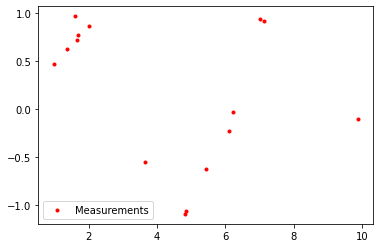

In [ ]:
#@title Create measurements {vertical-output: true}

# Plot measurements
meas_x = torch.rand(n_measurements)*x_range
meas_y = torch.sin(meas_x) + torch.normal(0, torch.full([n_measurements], data_std.item()))
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.show()


Factor Graph:
# Variable nodes: 20
# Factors: 34




/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:959: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.asarray(x)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:1368: FutureWarning: The inpu

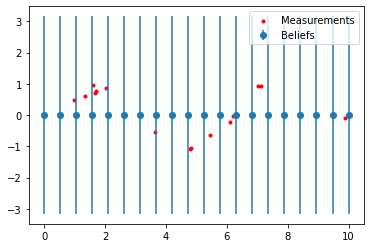

In [ ]:
#@title Create factor graph {vertical-output: true}
fg = FactorGraph(gbp_settings)

xs = torch.linspace(0, x_range, n_varnodes).float().unsqueeze(0).T
for i in range(n_varnodes):
    fg.add_var_node(1, torch.tensor([0.]), prior_cov)

for i in range(n_varnodes-1):
    fg.add_factor(
      [i, i+1], 
      torch.tensor([0.]), 
      SmoothingModel(SquaredLoss(1, smooth_cov))
      )

for i in range(n_measurements):
    ix2 = np.argmax(xs > meas_x[i])
    ix1 = ix2 - 1
    gamma = (meas_x[i] - xs[ix1]) / (xs[ix2] - xs[ix1])
    fg.add_factor(
      [ix1, ix2], 
      meas_y[i], 
      HeightMeasurementModel(
          SquaredLoss(1, data_cov), 
          gamma  
        )
      )

fg.print(brief=True)

#@markdown Beliefs are initialized to zero
# Plot beliefs and measurements
covs = torch.sqrt(torch.cat(fg.belief_covs()).flatten())
plt.errorbar(xs, fg.belief_means(), yerr=covs, fmt='o', color="C0", label='Beliefs')
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.show()


Initial Energy 81.98669
Iter 1  --- Energy 29.00060 --- 
Iter 2  --- Energy 22.04576 --- 
Iter 3  --- Energy 12.92844 --- 
Iter 4  --- Energy 11.69807 --- 
Iter 5  --- Energy 10.74326 --- 
Iter 6  --- Energy 10.38428 --- 
Iter 7  --- Energy 10.34638 --- 
Iter 8  --- Energy 10.30881 --- 
Iter 9  --- Energy 10.31084 --- 
Iter 10  --- Energy 10.30814 --- 
Iter 11  --- Energy 10.30247 --- 
Iter 12  --- Energy 10.30023 --- 
Iter 13  --- Energy 10.30016 --- 
Iter 14  --- Energy 10.29975 --- 
Iter 15  --- Energy 10.29978 --- 
Iter 16  --- Energy 10.29975 --- 
Iter 17  --- Energy 10.29972 --- 
Iter 18  --- Energy 10.29971 --- 
Iter 19  --- Energy 10.29971 --- 
Iter 20  --- Energy 10.29970 --- 
Iter 21  --- Energy 10.29970 --- 
Iter 22  --- Energy 10.29970 --- 
Iter 23  --- Energy 10.29970 --- 
Iter 24  --- Energy 10.29970 --- 
Iter 25  --- Energy 10.29970 --- 
Iter 26  --- Energy 10.29970 --- 
Iter 27  --- Energy 10.29970 --- 
Iter 28  --- Energy 10.29970 --- 


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:959: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.asarray(x)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:1368: FutureWarning: The inpu

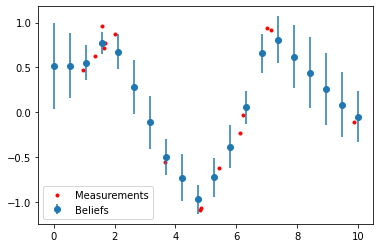

In [ ]:
#@title Solve with GBP {vertical-output: true}
fg.gbp_solve(n_iters=50)

# Plot beliefs and measurements
covs = torch.sqrt(torch.cat(fg.belief_covs()).flatten())
plt.errorbar(xs, fg.belief_means(), yerr=covs, fmt='o', color="C0", label='Beliefs')
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.show()

In [ ]:
def meas_fn(x):
    length = int(x.shape[0] / 2)
    J = torch.cat((-torch.eye(length), torch.eye(length)), dim=1)
    return J @ x


def jac_fn(x):
    length = int(x.shape[0] / 2)
    return torch.cat((-torch.eye(length), torch.eye(length)), dim=1)


class LinearDisplacementModel(MeasModel):
    def __init__(self, loss: SquaredLoss) -> None:
        MeasModel.__init__(self, meas_fn, jac_fn, loss)
        self.linear = True



In [ ]:
fg = FactorGraph(gbp_settings)

# Initialize variable nodes for frames with prior
for i in range(size):
    for j in range(size):
        init = torch.FloatTensor([j, i]) + torch.normal(torch.zeros(2), prior_noise_std)
        sigma = prior_sigma
        if i == 0 and j == 0:
            init = torch.FloatTensor([j, i])
            sigma = torch.tensor([0.001, 0.001])
        print(init, sigma)
        fg.add_var_node(2, init, sigma)

for i in range(size):
    for j in range(size):
        if j < size - 1:
            fg.add_factor(
                [i*size + j, i*size + j + 1],
                torch.tensor([1., 0.]) + torch.normal(torch.zeros(2), torch.sqrt(noise_cov[0])),
                CubedDisplacementModel(SquaredLoss(dim, noise_cov))
            )
        if i < size - 1:
            fg.add_factor(
                [i*size + j, (i+1)*size + j],
                torch.tensor([0., 1.]) + torch.normal(torch.zeros(2), torch.sqrt(noise_cov[0])),
                CubedDisplacementModel(SquaredLoss(dim, noise_cov))
            )

fg = gbp.FactorGraph(gbp_settings)

anchor_prior_diag_cov = torch.tensor([1.])
prior_diag_cov = torch.tensor([10.])
fg.add_var_node(1, torch.tensor([0.]), anchor_prior_diag_cov)
fg.add_var_node(1, torch.tensor([1.2]), prior_diag_cov)
fg.add_var_node(1, torch.tensor([3.2]), prior_diag_cov)


meas_dofs = 1
noise_diag_cov = torch.tensor([1.])
transition_stds = 0.5

# fg.add_factor([0, 1], torch.tensor([1.]), LinearDisplacementModel(HuberLoss(meas_dofs, noise_diag_cov, transition_stds)))
# fg.add_factor([1, 2], torch.tensor([1.]), LinearDisplacementModel(HuberLoss(meas_dofs, noise_diag_cov, transition_stds)))
fg.add_factor([0, 1], torch.tensor([1.]), LinearDisplacementModel(SquaredLoss(meas_dofs, noise_diag_cov)))
fg.add_factor([1, 2], torch.tensor([1.]), LinearDisplacementModel(SquaredLoss(meas_dofs, noise_diag_cov)))

fg.print()

print("Initial belief means", fg.belief_means().numpy())

joint = fg.get_joint()
print("MAP: ", fg.MAP().numpy())


NameError: ignored